In [3]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, LSTM, TimeDistributed, Activation, SimpleRNN
from keras import losses
import keras.backend as K

## Make data: global monotonic curvature with riple and noise

In [2]:
def base(x):
    return 1/(1 + np.exp(10*(x - 0.5)))

def ripple(x):
    return np.sin(30 * (x))

def ripple2d(x, y, x_offset, y_offset):
    return np.sin(10 * (x - x_offset)) - np.cos(10 * (y - y_offset)) 

m = 2              # number of dimensions
k = 10             # length of one series
n = 10000          # samples

x = np.zeros((n, k, m))
y = np.zeros(n)

# One input sample is k x m matrix
# We generate a random smooth input matrix x independed from the output  
# And then generate target label y from x_{0,0}
# So the goal is to learn a monotonic approximation of the dependency between x_{0,0} and y 
for i in range(n):                         
    x1_axis = np.linspace(0, 1, k)
    x2_axis = np.linspace(0, 1, m)

    X1, X2 = np.meshgrid(x1_axis, x2_axis)
    X = ripple2d(X1, X2, np.random.uniform(0.0, 1.0, 1), np.random.uniform(0.0, 1.0, 1)) + np.random.normal(0, 0.5, (m, k))    # base input matrix

    X[0, 0] = np.random.uniform(0.0, 1.0, 1)
    y[i] = base(X[0, 0]) + 0.15*ripple(X[0, 0]) + np.random.normal(0, 0.08, 1)
    
    x[i, :] = np.transpose(X)

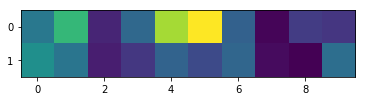

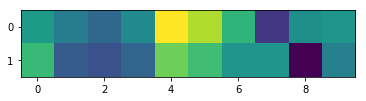

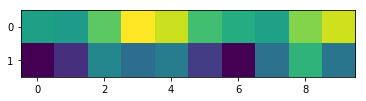

In [4]:
# Individual input samples
for i in range(3):
    plt.imshow(np.transpose(x[i, :]))
    plt.show()

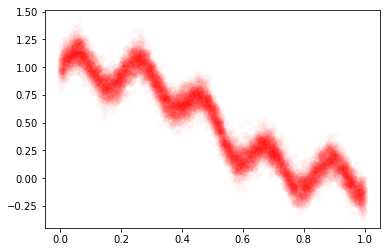

In [5]:
# The dependency between x_{0,0} and y ~ sigmoid + ripple + noise
plt.plot(x[:, 0, 0], y, 'ro', alpha=0.02)
plt.show()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

## Make a model: LSTM with a sufficently high capacity to capture the curvature of the ripple

In [7]:
def create_model():
    inputs = Input(shape=(k, m))
    layer1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
    layer2 = LSTM(128, activation='relu')(layer1)
    predictions = Dense(1, activation='linear')(layer2)
    return (Model(inputs=inputs, outputs=predictions), inputs)

In [8]:
model, inputs = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           67072     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________


## Baseline: regular model fitting

In [9]:
model, inputs = create_model()

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error']) 
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 5s 839us/step - loss: 0.1761 - mean_absolute_error: 0.3689 - val_loss: 0.0956 - val_mean_absolute_error: 0.2565
Epoch 2/20
6400/6400 [==============================] - 4s 617us/step - loss: 0.0442 - mean_absolute_error: 0.1638 - val_loss: 0.0241 - val_mean_absolute_error: 0.1256
Epoch 3/20
6400/6400 [==============================] - 4s 637us/step - loss: 0.0203 - mean_absolute_error: 0.1161 - val_loss: 0.0194 - val_mean_absolute_error: 0.1126
Epoch 4/20
6400/6400 [==============================] - 4s 575us/step - loss: 0.0194 - mean_absolute_error: 0.1140 - val_loss: 0.0241 - val_mean_absolute_error: 0.1258
Epoch 5/20
6400/6400 [==============================] - 4s 582us/step - loss: 0.0193 - mean_absolute_error: 0.1139 - val_loss: 0.0189 - val_mean_absolute_error: 0.1107
Epoch 6/20
6400/6400 [==============================] - 4s 602us

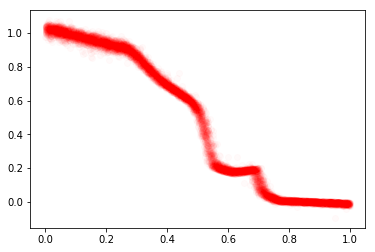

In [10]:
y_pred = model.predict(x)

plt.plot(x[:, 0, 0], y_pred, 'ro', alpha=0.02)
plt.show()

## Monotonic approximation

In [13]:
def custom_loss(model, input_tensor):
    def loss(y_true, y_pred):
        
        #grads = K.gradients(model.output, model.input)[0] 
        #loss_f = losses.mean_squared_error(y_true, y_pred) #+ 0.8 * K.exp( - K.sum(K.square(K.sum(K.softsign(grads), axis=0))))
        #return loss_f
        
        ls = losses.mean_squared_error(y_true, y_pred)
        grads = K.gradients(ls, model.input)[0] 
        return grads

   
    return loss

model_reg, inputs_reg = create_model()
model_reg.compile(optimizer='adam', loss=custom_loss(model_reg, inputs_reg), metrics=['mean_absolute_error'])
history = model_reg.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val)) 
score = model_reg.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

TypeError: Second-order gradient for while loops not supported.